In [1]:
import pandas as pd
from pandas import DataFrame, Series
#false positive warnings all the time:
pd.options.mode.chained_assignment = None

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import statistics

import os.path


In [2]:
#http://matplotlib.org/1.4.0/users/customizing.html

plt.style.use('ggplot')

mpl.rcParams['font.size'] = 18

### LINES
mpl.rcParams['lines.linewidth'] = '2.0'        # line width in points
mpl.rcParams['lines.marker']    = 'None'
mpl.rcParams['lines.markersize']=  '6'          # markersize, in points

###LEGEND
mpl.rcParams['legend.fontsize']='medium'

### GRIDS
mpl.rcParams['grid.color']='black'     # grid color
mpl.rcParams['grid.linestyle'] =':'    # dotted
mpl.rcParams['grid.linewidth']='0.5'   # in points
mpl.rcParams['grid.alpha']='1.0'       # transparency, between 0.0 and 1.0

### TICKS
mpl.rcParams['xtick.labelsize']="small"  # fontsize of the tick labels
mpl.rcParams['xtick.direction']="out"      # direction: in, out, or inout
mpl.rcParams['ytick.labelsize']="small"   # fontsize of the tick labels
mpl.rcParams['ytick.direction']="out"      # direction: in, out, or inout

### AXES
mpl.rcParams['axes.linewidth']  =  '1.0'    # edge linewidth
mpl.rcParams['axes.grid']       =  'True'   # display grid or not
mpl.rcParams['axes.titlesize']  =  'large'  # fontsize of the axes title
mpl.rcParams['axes.labelsize']  = 'large'  # fontsize of the x any y labels
mpl.rcParams['axes.facecolor']= 'white'     # axes background color

mpl.rcParams['figure.facecolor']= '1.0'     # figure facecolor; 0.75 is scalar gray

# 1. Benchmark survival single sim

* Per thread ID find the highest order_id which is flagged 'SUCCESS'

In [3]:
def generateFilename(bmtuple):
    fname = './csv/' +  bmtuple[0] + "_N" + str(bmtuple[1]) + "_" + str(bmtuple[2]) + "_" + bmtuple[3] + "_" + bmtuple[4]
    if len(str(bmtuple[5])) != 0:
        fname = fname + "_" + str(bmtuple[5])
    return fname + "_queryevents.csv"

In [4]:
generateFilename(('Virtuoso', 3,64,'Ontoforce', 'Optimized', '0'))

'./csv/Virtuoso_N3_64_Ontoforce_Optimized_0_queryevents.csv'

In [5]:
df = pd.read_csv(generateFilename(('Virtuoso', 3,64,'Ontoforce', 'Optimized', '0')), sep="\t")

In [6]:
print(df.shape)
df_filter_success = df[df['flag'] == 'SUCCESS']
print(df_filter_success.shape)

(7338, 8)
(4137, 8)


In [7]:
df_survival = df_filter_success.groupby(['thread_id', 'thread_type'], as_index=False)[['sim_id','order_id']].max()
df_survival

,thread_id,thread_type,sim_id,order_id
0,1,warmup,Vir_N3_64_Ont_Opt_0,1223
1,22,stress,Vir_N3_64_Ont_Opt_0,888
2,23,stress,Vir_N3_64_Ont_Opt_0,707
3,24,stress,Vir_N3_64_Ont_Opt_0,652
4,25,stress,Vir_N3_64_Ont_Opt_0,402
5,26,stress,Vir_N3_64_Ont_Opt_0,441


In [8]:
df_survival[['sim_id', 'order_id']]['sim_id'][0]

'Vir_N3_64_Ont_Opt_0'

# 2. Benchmark survival list of sims


In [9]:
tuple_list = [('Virtuoso', 3, 64,'Ontoforce', 'Optimized', '0'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', '1'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', '2'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', 'AWS1'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', 'AWS2'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', 'AWS3')]

In [10]:
survival_tuples = []

for tup in tuple_list:
    full_path = generateFilename(tup)
    
    if os.path.isfile(full_path):
        df = pd.read_csv(full_path, sep="\t")
        df_filter_success = df[df['flag'] == 'SUCCESS']
        df_survival = df_filter_success.groupby(['thread_id', 'thread_type'], as_index=False)[['sim_id','order_id']].max()
        survival_tuple = (df_survival['sim_id'][0], df_survival['order_id'].sum())
        survival_tuples.append(survival_tuple)
    
print(survival_tuples)

[('Vir_N3_64_Ont_Opt_0', 4313), ('Vir_N3_64_Ont_Opt_1', 179), ('Vir_N3_64_Ont_Opt_2', 7338), ('Vir_N3_64_Ont_Opt_AWS1', 116), ('Vir_N3_64_Ont_Opt_AWS2', 224), ('Vir_N3_64_Ont_Opt_AWS3', 228)]


In [11]:
ind = [ tup[0] for tup in survival_tuples ]
val = [ tup[1] for tup in survival_tuples ]
test_df = pd.DataFrame(val, index=ind, columns=['survival'])

In [12]:
test_df

,survival
Vir_N3_64_Ont_Opt_0,4313
Vir_N3_64_Ont_Opt_1,179
Vir_N3_64_Ont_Opt_2,7338
Vir_N3_64_Ont_Opt_AWS1,116
Vir_N3_64_Ont_Opt_AWS2,224
Vir_N3_64_Ont_Opt_AWS3,228


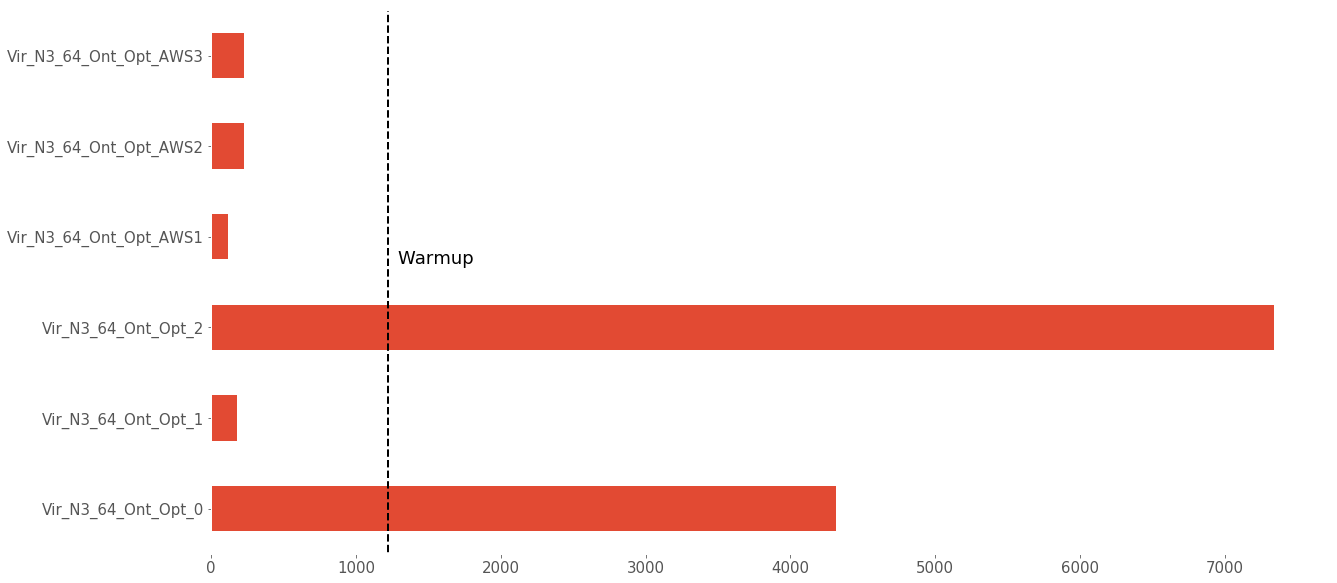

In [13]:
def plotQuerySurvival(df, number_of_queries, fsize):
    
    fig, ax = plt.subplots(1, 1, figsize=fsize)
    ax.plot([number_of_queries,number_of_queries],[-1,df.shape[0]+1], linestyle='--', color='black')
    ax.text(number_of_queries*1.05,df.shape[0]*0.45,'Warmup')
    df.plot(kind='barh', ax=ax, legend=False, grid=False)

    
    return fig
    

fig = plotQuerySurvival(test_df, 1223, (20,10))
#fig.savefig('QuerySurvival_VirtuosoN3_64.svg', format='svg', bbox_inches='tight', dpi=1200)
#fig.savefig('QuerySurvival_VirtuosoN3_64.eps', format='eps', bbox_inches='tight', dpi=1200)

In [14]:
def generateBenchmarkSurvivalPlot(bmtuples, fsize, fname, querymixsize):
    survival_tuples = []

    for tup in bmtuples:
        full_path = generateFilename(tup)

        if os.path.isfile(full_path):
            df = pd.read_csv(full_path, sep="\t")
            df_filter_success = df[df['flag'] == 'SUCCESS']
            if df_filter_success.shape[0] == 0:
                continue
            df_survival = df_filter_success.groupby(['thread_id', 'thread_type'], as_index=False)[['sim_id','order_id']].max()
            survival_tuple = (df_survival['sim_id'][0], df_survival['order_id'].sum())
            survival_tuples.append(survival_tuple)
    
    print(survival_tuples)
    
    ind = [ tup[0] for tup in survival_tuples ]
    val = [ tup[1] for tup in survival_tuples ]
    test_df = pd.DataFrame(val, index=ind, columns=['survival'])
    
    fig = plotQuerySurvival(test_df, querymixsize, (20,10))
    fig.savefig(fname + '.svg', format='svg', bbox_inches='tight', dpi=1200)
    fig.savefig(fname + '.eps', format='eps', bbox_inches='tight', dpi=1200)
    
    pass
    

### TEST

[('Vir_N3_64_Ont_Opt_0', 4313), ('Vir_N3_64_Ont_Opt_1', 179), ('Vir_N3_64_Ont_Opt_2', 7338), ('Vir_N3_64_Ont_Opt_AWS1', 116), ('Vir_N3_64_Ont_Opt_AWS2', 224), ('Vir_N3_64_Ont_Opt_AWS3', 228)]


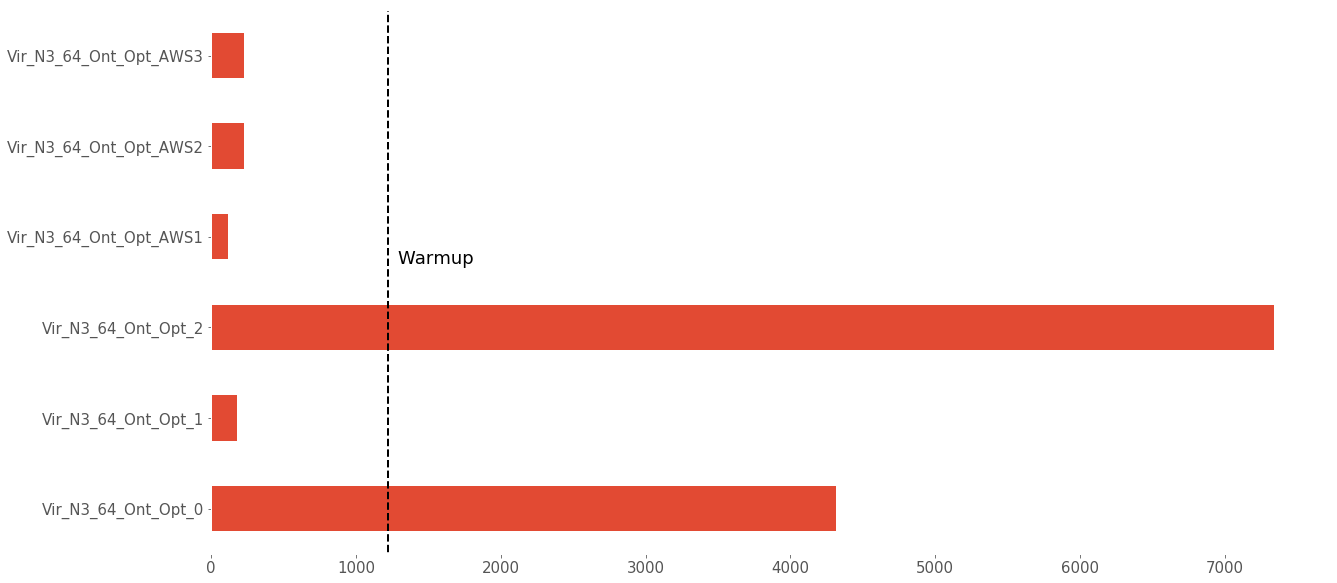

In [15]:
generateBenchmarkSurvivalPlot(tuple_list, (20,10), './img/benchmark_survival/BenchmarkSurvival_Virtuoso_N3_64_Ontoforce_Optimized', 1223)

# 3. Generate Survival plots 

## Overview configs:

* Watdiv10M: warmups: 3, mix runs: 10, queries_in_mix: 2000
* Watdiv1000M_32: warmups: 1, mix_runs: 5, queries_in_mix: 2000
* Watdiv1000M_64, optimized: warmups: 1, mix_runs: 5, queries_in_mix: 400
* Ontoforce: same, queries_in_mix: 1223


## 1. Enterprise stores Watdiv10M

[('Bla_N1_32_W10_Def', 26000), ('Gra_N1_32_W10_Def', 26000), ('ES_N1_32_W10_Def', 26000), ('Vir_N1_32_W10_Def', 26000)]


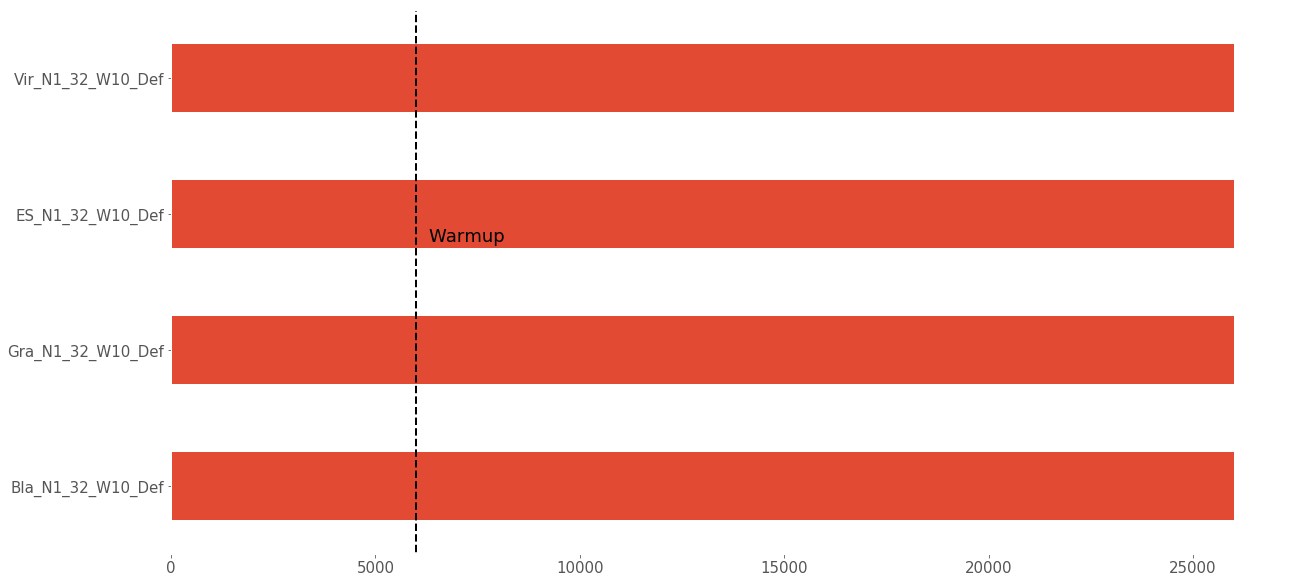

In [16]:
tuple_list = [('Blazegraph', 1, 32,'Watdiv10M', 'Default', ''), \
    ('GraphDB', 1, 32,'Watdiv10M', 'Default', ''), \
    ('ES', 1, 32,'Watdiv10M', 'Default', ''), \
    ('Virtuoso', 1, 32,'Watdiv10M', 'Default', '')]   
generateBenchmarkSurvivalPlot(tuple_list, (20,10), './img/benchmark_survival/BenchmarkSurvival_NoSQL_N1_32_Watdiv10M_Default', 6000)

## 2. Enterprise stores Watdiv100M

[('Bla_N1_32_W100_Def', 26000), ('Gra_N1_32_W100_Def', 26000), ('Vir_N1_32_W100_Def', 26000)]


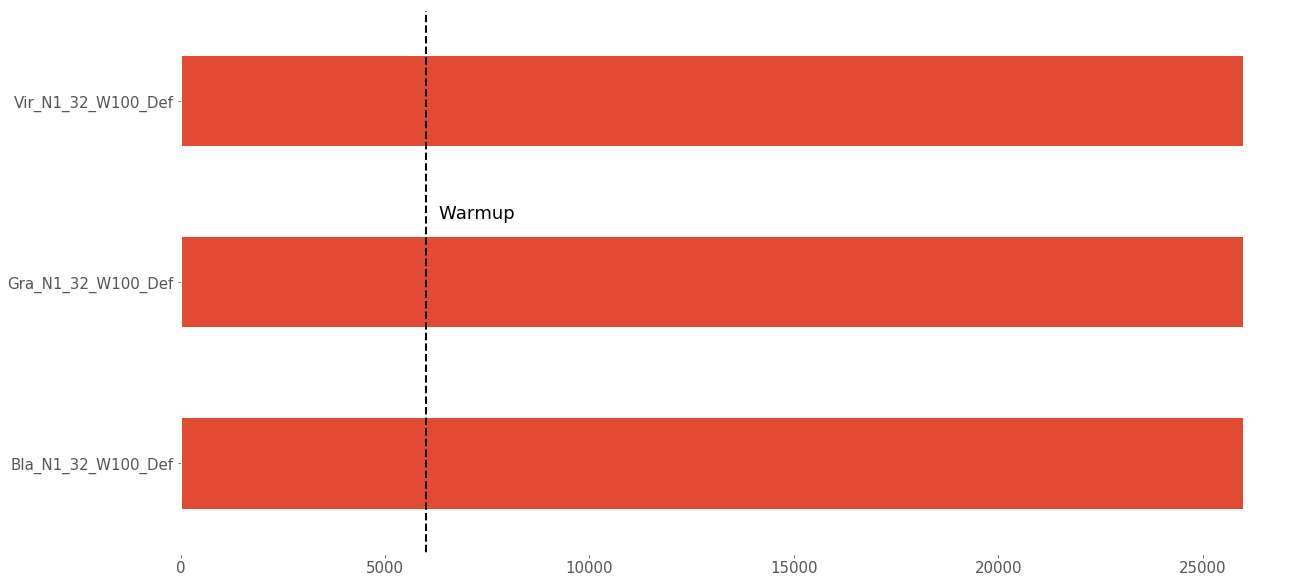

In [17]:
tuple_list = [('Blazegraph', 1, 32,'Watdiv100M', 'Default', ''), \
    ('GraphDB', 1, 32,'Watdiv100M', 'Default', ''), \
    ('ES', 1, 32,'Watdiv100M', 'Default', ''), \
    ('Virtuoso', 1, 32,'Watdiv100M', 'Default', '')]   
generateBenchmarkSurvivalPlot(tuple_list, (20,10), './img/benchmark_survival/BenchmarkSurvival_NoSQL_N1_32_Watdiv100M_Default', 6000)

## 3. Enterprise stores Watdiv1000M

### A. 1 node, 32 GB RAM, Default Configs

[('Bla_N1_32_W1000_Def', 8001), ('ES_N1_32_W1000_Def', 5836), ('Vir_N1_32_W1000_Def', 12000)]


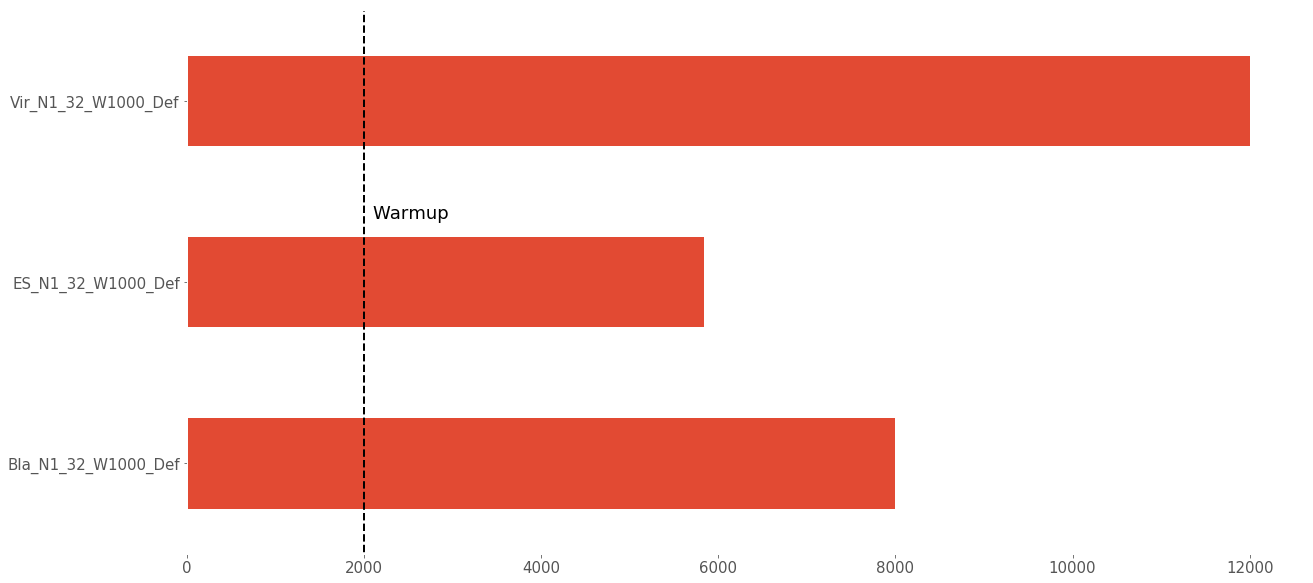

In [18]:
tuple_list = [('Blazegraph', 1, 32,'Watdiv1000M', 'Default', ''), \
    ('GraphDB', 1, 32,'Watdiv1000M', 'Default', ''), \
    ('ES', 1, 32,'Watdiv1000M', 'Default', ''), \
    ('Virtuoso', 1, 32,'Watdiv1000M', 'Default', '')]   
generateBenchmarkSurvivalPlot(tuple_list, (20,10), './img/benchmark_survival/BenchmarkSurvival_N1_32_Watdiv1000M_Default', 2000)

### B. 1 node, 64 GB RAM, Default Configs¶



[('Bla_N1_64_W1000_Def', 2400), ('Gra_N1_64_W1000_Def', 2400), ('ES_N1_64_W1000_Def', 2399), ('Vir_N1_64_W1000_Def', 2400)]


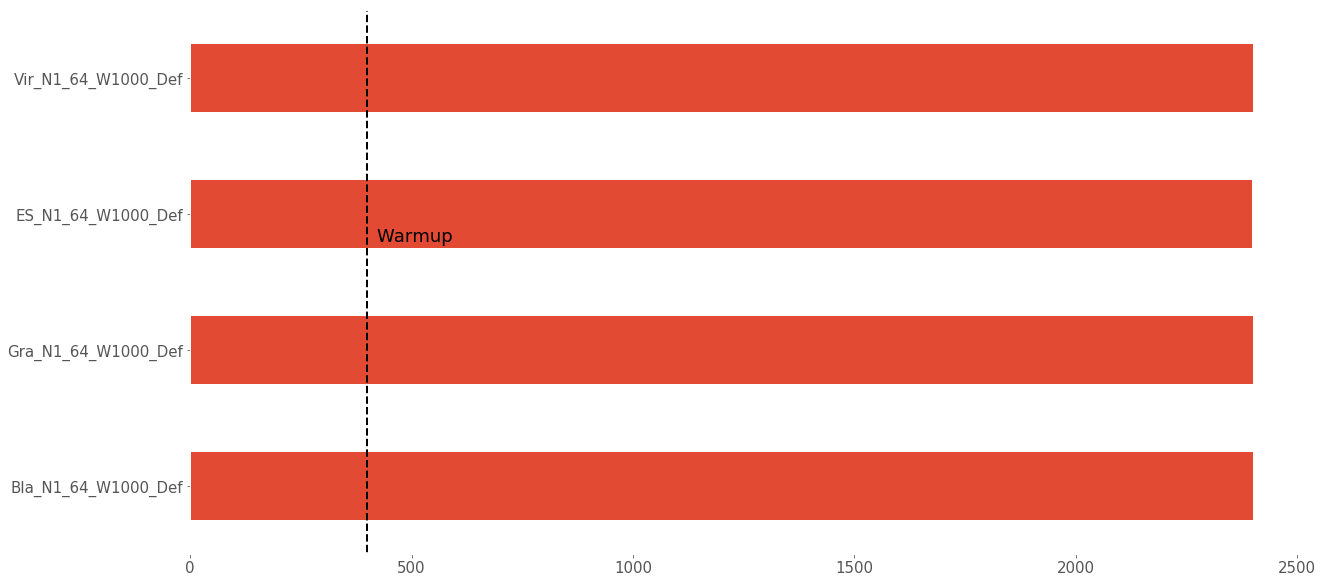

In [19]:
tuple_list = [('Blazegraph', 1, 64,'Watdiv1000M', 'Default', ''), \
    ('GraphDB', 1, 64,'Watdiv1000M', 'Default', ''), \
    ('ES', 1, 64,'Watdiv1000M', 'Default', ''), \
    ('Virtuoso', 1, 64,'Watdiv1000M', 'Default', '')]   
generateBenchmarkSurvivalPlot(tuple_list, (20,10), './img/benchmark_survival/BenchmarkSurvival_N1_64_Watdiv1000M_Default', 400)

### C. 1 node, 64 GB RAM, Optimized Configs¶



[('Bla_N1_64_W1000_Opt', 2400), ('Gra_N1_64_W1000_Opt', 2400), ('Vir_N1_64_W1000_Opt', 2400)]


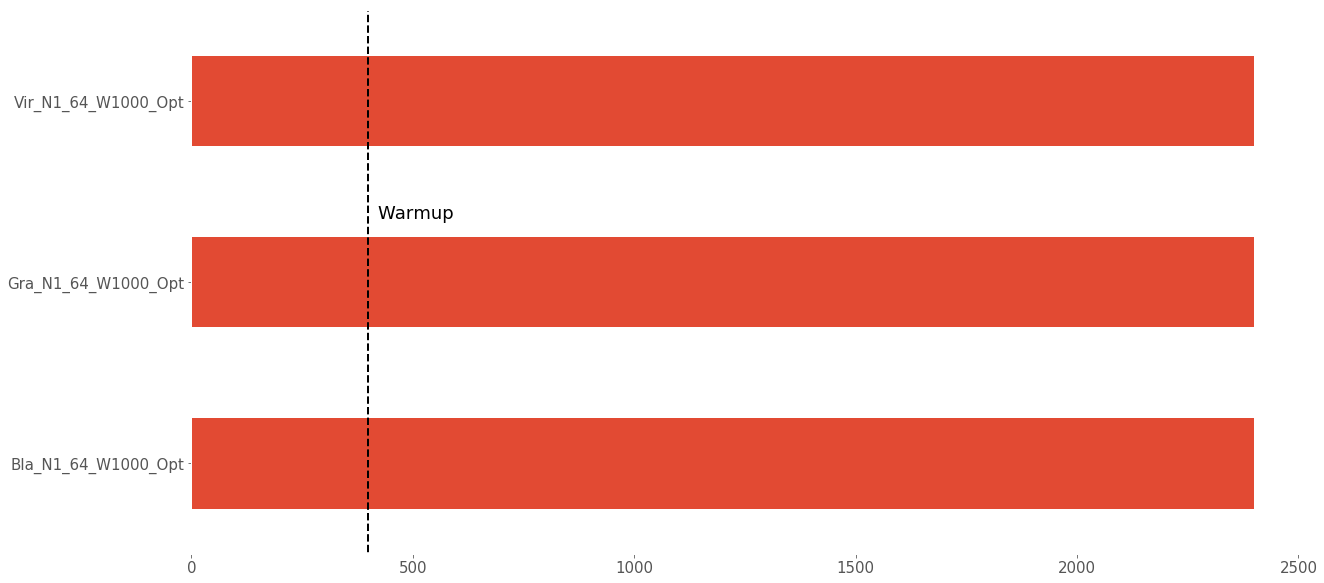

In [20]:
tuple_list = [('Blazegraph', 1, 64,'Watdiv1000M', 'Optimized', ''), \
    ('GraphDB', 1, 64,'Watdiv1000M', 'Optimized', ''), \
    ('ES', 1, 64,'Watdiv1000M', 'Optimized', ''), \
    ('Virtuoso', 1, 64,'Watdiv1000M', 'Optimized', '')]   
generateBenchmarkSurvivalPlot(tuple_list, (20,10), './img/benchmark_survival/BenchmarkSurvival_N1_64_Watdiv1000M_Optimized', 400)

## 4. Enterprise stores Watdiv1000M Multi-Node

### A. 3 node, 32 GB RAM, Default Configs

[('ES_N3_32_W1000_Def', 8684), ('Vir_N3_32_W1000_Def', 12000)]


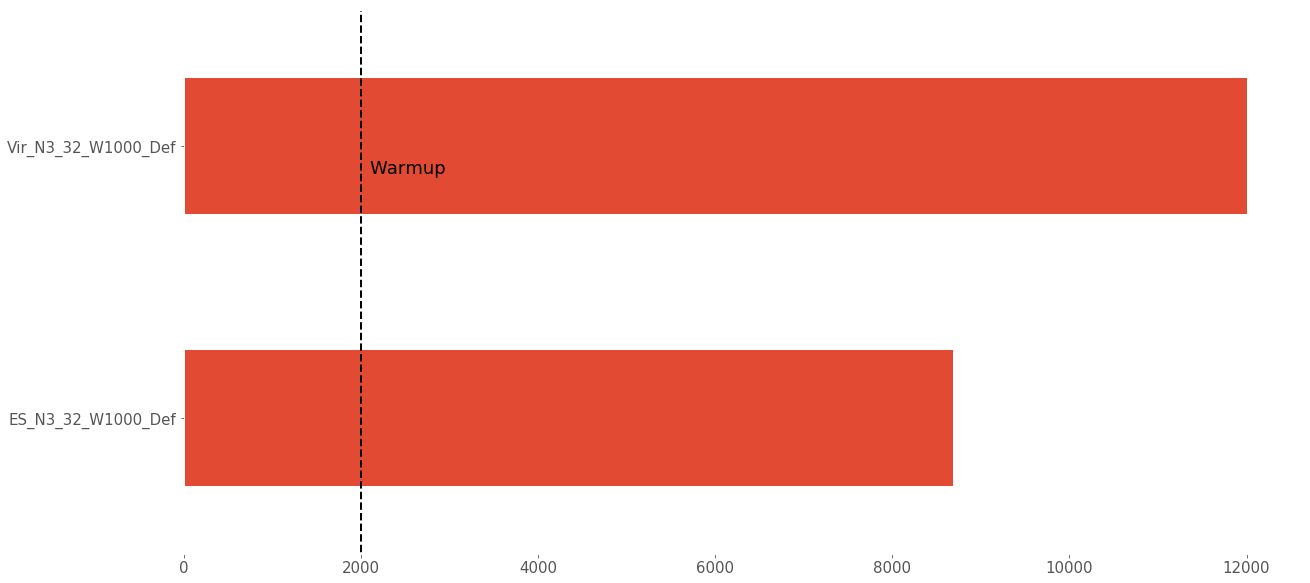

In [21]:
tuple_list = [('Blazegraph', 3, 32,'Watdiv1000M', 'Default', ''), \
    ('GraphDB', 3, 32,'Watdiv1000M', 'Default', ''), \
    ('ES', 3, 32,'Watdiv1000M', 'Default', ''), \
    ('Virtuoso', 3, 32,'Watdiv1000M', 'Default', '')]   
generateBenchmarkSurvivalPlot(tuple_list, (20,10), './img/benchmark_survival/BenchmarkSurvival_N3_32_Watdiv1000M_Default', 2000)

## 5.  Other stores for horizontal scaling

* Fuseki, FluidOps, LDF

### A. Watdiv 100M




[('Fus_N1_64_W100_Def', 655), ('LDF_N1_64_W100_Def', 2399), ('LDF_N3_64_W100_Def', 2400), ('Flu_N3_64_W100_Def', 40)]


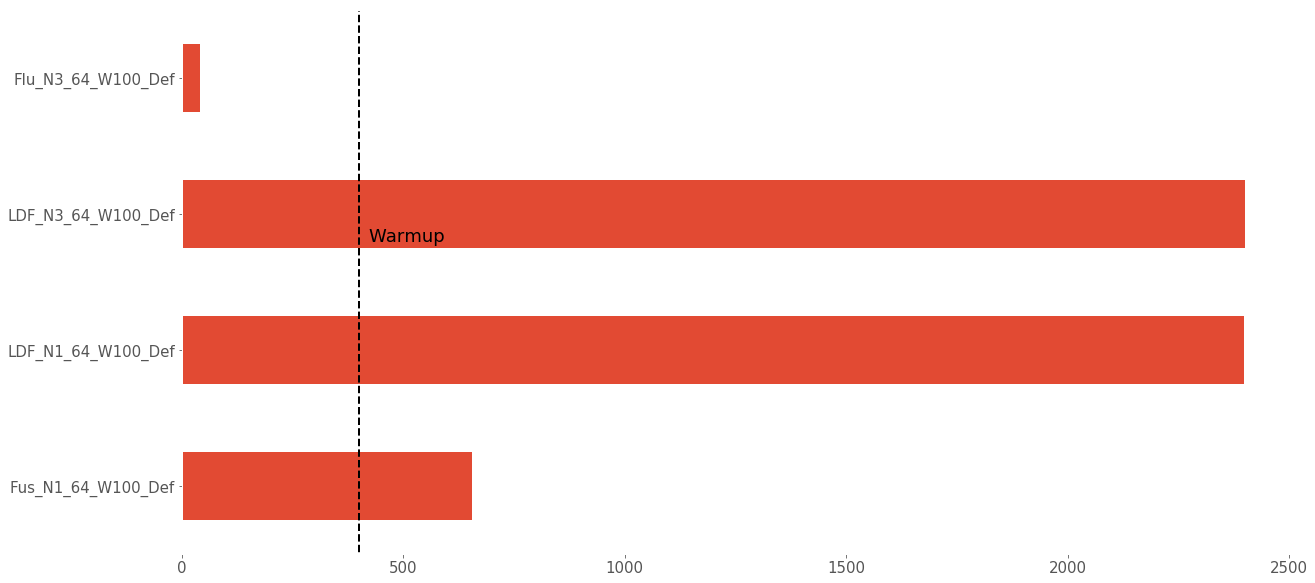

In [22]:
tuple_list = [('Fuseki', 1, 64,'Watdiv100M', 'Default', ''), \
    ('LDF', 1, 64,'Watdiv100M', 'Default', ''), \
    ('LDF', 3, 64,'Watdiv100M', 'Default', ''), \
    ('FluidOps', 3, 64,'Watdiv100M', 'Default', '')]

generateBenchmarkSurvivalPlot(tuple_list, (20,10), './img/benchmark_survival/BenchmarkSurvival_HScaling_N3_64_Watdiv100M_Default', 400)

### B. Watdiv 1000M


[('Fus_N1_64_W1000_Def', 51), ('LDF_N1_64_W1000_Def', 2390), ('LDF_N3_64_W1000_Def', 2394), ('Flu_N1_64_W1000_Def', 2400), ('Flu_N3_64_W1000_Def', 4)]


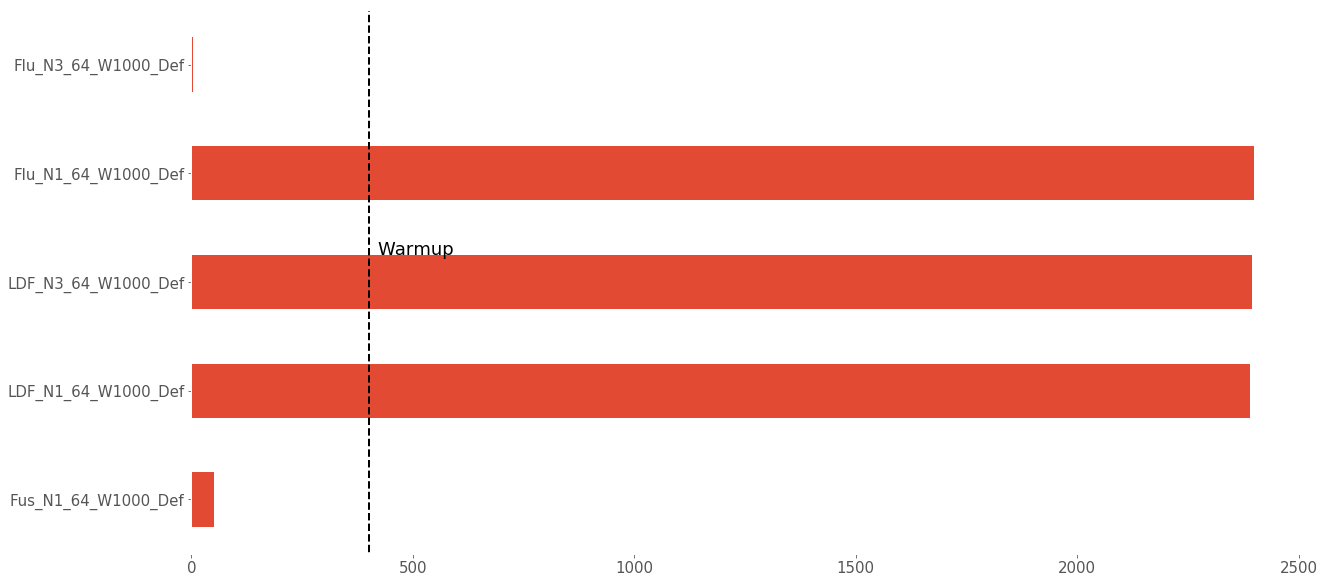

In [23]:
tuple_list = [('Fuseki', 1, 64,'Watdiv1000M', 'Default', ''), \
    ('LDF', 1, 64,'Watdiv1000M', 'Default', ''), \
    ('LDF', 3, 64,'Watdiv1000M', 'Default', ''), \
    ('FluidOps', 1, 64,'Watdiv1000M', 'Default', ''), \
    ('FluidOps', 3, 64,'Watdiv1000M', 'Default', '')]

generateBenchmarkSurvivalPlot(tuple_list, (20,10), './img/benchmark_survival/BenchmarkSurvival_HScaling_N3_64_Watdiv1000M_Default', 400)

[('Fus_N1_64_W1000_Def', 51), ('LDF_N1_64_W1000_Def', 2390), ('LDF_N3_64_W1000_Def', 2394), ('Flu_N1_64_W1000_Def', 2400), ('Flu_N3_64_W1000_Def', 4), ('Fus_N1_64_W100_Def', 655), ('LDF_N1_64_W100_Def', 2399), ('LDF_N3_64_W100_Def', 2400), ('Flu_N3_64_W100_Def', 40)]


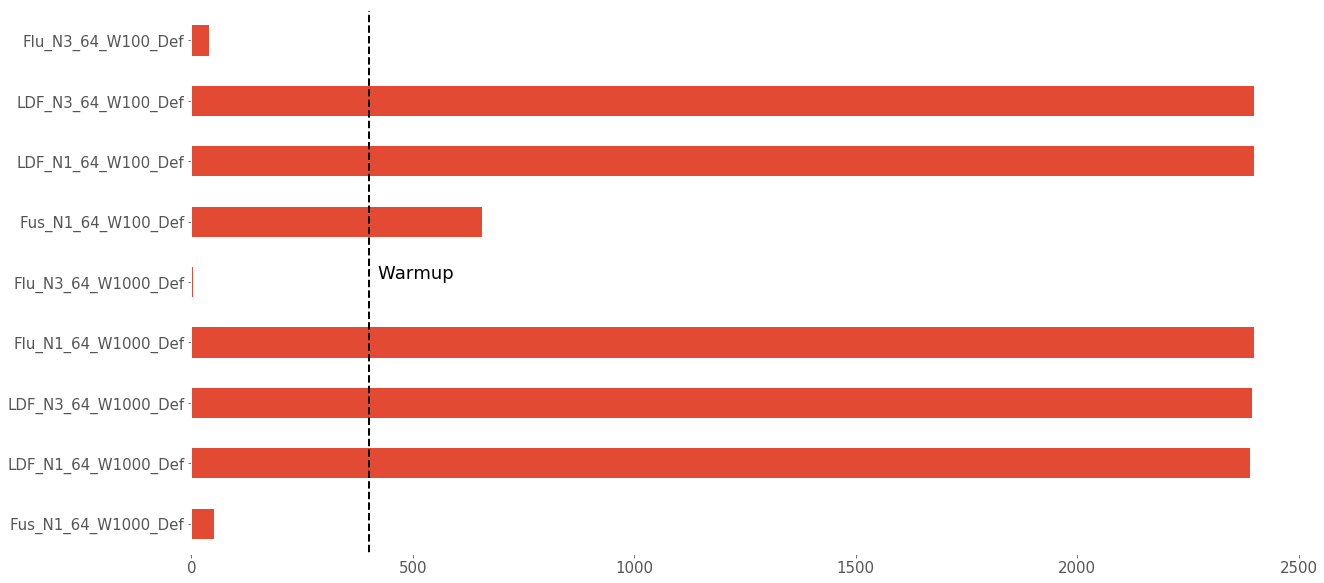

In [25]:
list1 = [('Fuseki', 1, 64,'Watdiv100M', 'Default', ''), \
    ('LDF', 1, 64,'Watdiv100M', 'Default', ''), \
    ('LDF', 3, 64,'Watdiv100M', 'Default', ''), \
    ('FluidOps', 3, 64,'Watdiv100M', 'Default', '')]
list2 = [('Fuseki', 1, 64,'Watdiv1000M', 'Default', ''), \
    ('LDF', 1, 64,'Watdiv1000M', 'Default', ''), \
    ('LDF', 3, 64,'Watdiv1000M', 'Default', ''), \
    ('FluidOps', 1, 64,'Watdiv1000M', 'Default', ''), \
    ('FluidOps', 3, 64,'Watdiv1000M', 'Default', '')]

tuple_list = list2 + list1
generateBenchmarkSurvivalPlot(tuple_list, (20,10), './img/benchmark_survival/BenchmarkSurvival_Other_Watdiv_Default', 400)

## 6. Ontoforce Dataset

### A. Single Node Enterprise systems

[('Bla_N1_64_Ont_Opt', 55), ('Gra_N1_64_Ont_Opt', 2541), ('ES_N1_64_Ont_Def', 7335), ('Vir_N1_64_Ont_Opt', 7338)]


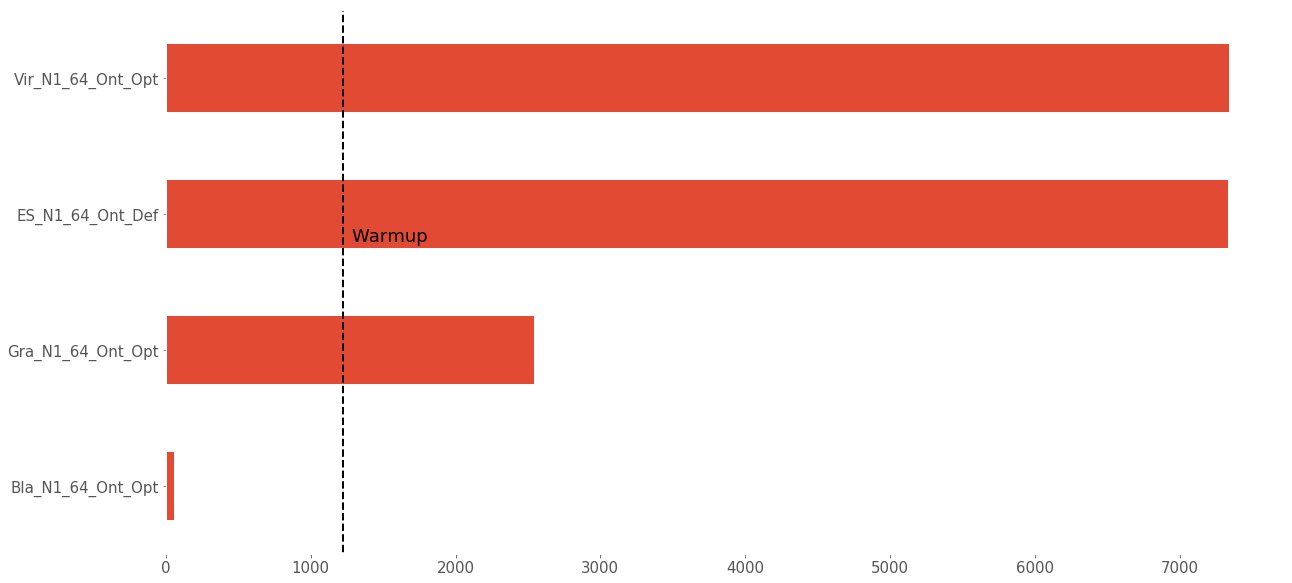

In [26]:
tuple_list = [('Blazegraph', 1, 64,'Ontoforce', 'Optimized', ''), \
    ('GraphDB', 1, 64,'Ontoforce', 'Optimized', ''), \
    ('ES', 1, 64,'Ontoforce', 'Default', ''), \
    ('Virtuoso', 1, 64,'Ontoforce', 'Optimized', '')]

generateBenchmarkSurvivalPlot(tuple_list, (20,10), './img/benchmark_survival/BenchmarkSurvival_Ontoforce_NoSQLsystems', 1223)

### B. Scaling approaches: vertical, horizontal, federation, compression

[('Vir_N1_32_Ont_Opt', 7338), ('Vir_N1_32_Ont_Opt_VWall', 7338), ('Vir_N1_64_Ont_Opt', 7338), ('Vir_N1_64_Ont_Opt_VWall', 7338), ('Vir_N3_64_Ont_Opt_0', 4313), ('Vir_N3_64_Ont_Opt_1', 179), ('Vir_N3_64_Ont_Opt_2', 7338), ('Vir_N3_64_Ont_Opt_AWS1', 116), ('Vir_N3_64_Ont_Opt_AWS2', 224), ('Vir_N3_64_Ont_Opt_AWS3', 228), ('Fus_N1_64_Ont_Def', 884), ('Flu_N1_64_Ont_Def_1', 2612), ('Flu_N1_64_Ont_Def_2', 174), ('Flu_N1_64_Ont_Def_3', 7326), ('Flu_N3_64_Ont_Def_1', 10), ('Flu_N3_64_Ont_Def_2', 5)]


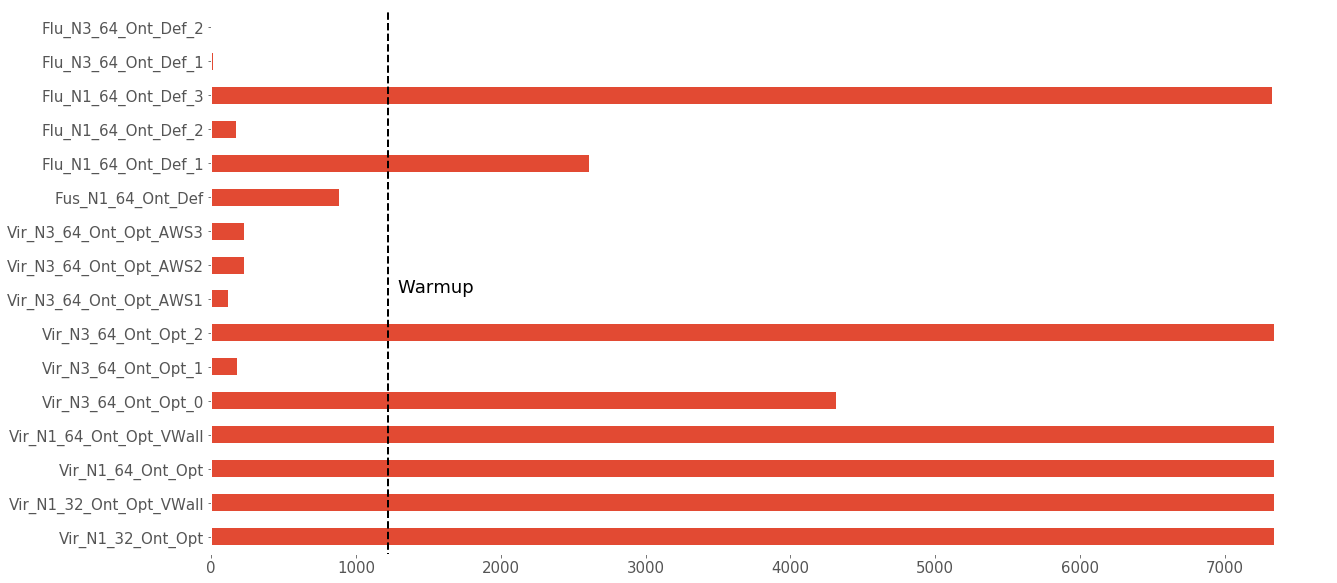

In [27]:
tuple_list = [('Virtuoso', 1, 32,'Ontoforce', 'Optimized', ''), \
    ('Virtuoso', 1, 32,'Ontoforce', 'Optimized', 'VWall'), \
    ('Virtuoso', 1, 64,'Ontoforce', 'Optimized', ''), \
    ('Virtuoso', 1, 64,'Ontoforce', 'Optimized', 'VWall'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', '0'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', '1'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', '2'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', 'AWS1'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', 'AWS2'), \
    ('Virtuoso', 3, 64,'Ontoforce', 'Optimized', 'AWS3'), \
    ('Fuseki', 1, 64,'Ontoforce', 'Default', ''), \
    ('FluidOps', 1, 64,'Ontoforce', 'Default', '1'), \
    ('FluidOps', 1, 64,'Ontoforce', 'Default', '2'), \
    ('FluidOps', 1, 64,'Ontoforce', 'Default', '3'), \
    ('FluidOps', 3, 64,'Ontoforce', 'Default', '1'), \
    ('FluidOps', 3, 64,'Ontoforce', 'Default', '2'), \
    ('FluidOps', 3, 64,'Ontoforce', 'Default', '3')]

generateBenchmarkSurvivalPlot(tuple_list, (20,20), './img/benchmark_survival/BenchmarkSurvival_Ontoforce_Multinode', 1223)

## 7. Images for paper

[('Fus_N1_64_W1000_Def', 51), ('LDF_N1_64_W1000_Def', 2390), ('LDF_N3_64_W1000_Def', 2394), ('Flu_N1_64_W1000_Def', 2400), ('Flu_N3_64_W1000_Def', 4), ('Fus_N1_64_W100_Def', 655), ('LDF_N1_64_W100_Def', 2399), ('LDF_N3_64_W100_Def', 2400), ('Flu_N3_64_W100_Def', 40)]


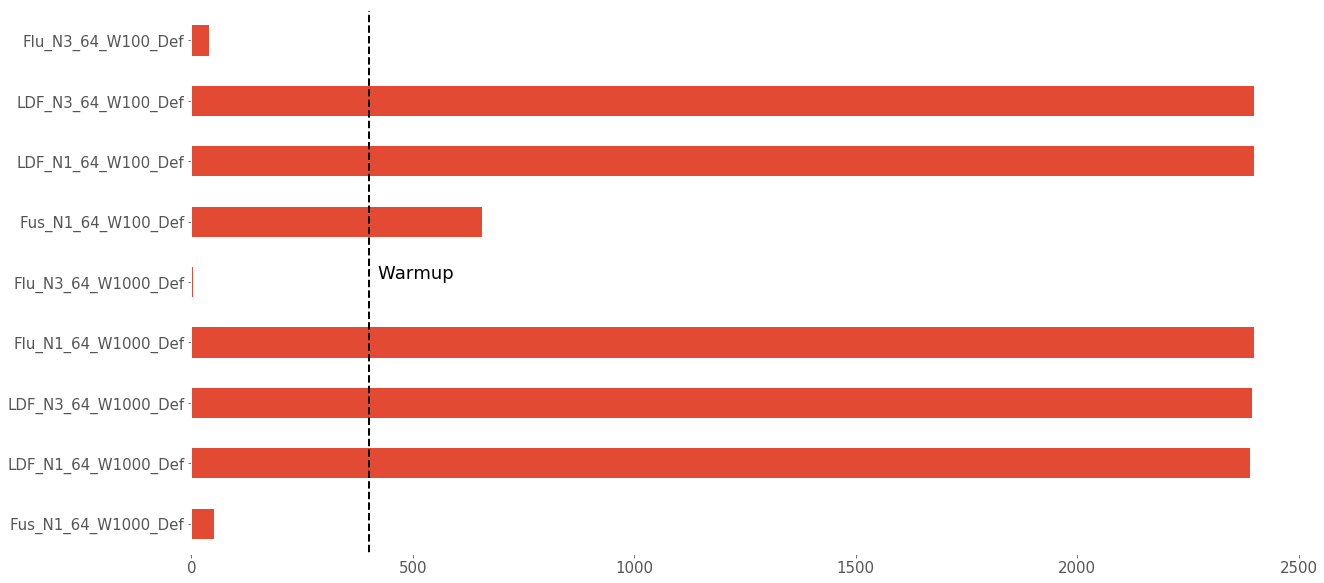

In [29]:
tuple_list = [
    ('Fuseki', 1, 64,'Watdiv1000M', 'Default', ''), \
    ('LDF', 1, 64,'Watdiv1000M', 'Default', ''), \
    ('LDF', 3, 64,'Watdiv1000M', 'Default', ''), \
    ('FluidOps', 1, 64,'Watdiv1000M', 'Default', ''), \
    ('FluidOps', 3, 64,'Watdiv1000M', 'Default', ''), \
#    ('Virtuoso', 3, 32,'Watdiv1000M', 'Default', ''), \
#    ('ES', 3, 32,'Watdiv1000M', 'Default', ''), \
    ('Fuseki', 1, 64,'Watdiv100M', 'Default', ''), \
    ('LDF', 1, 64,'Watdiv100M', 'Default', ''), \
    ('LDF', 3, 64,'Watdiv100M', 'Default', ''), \
    ('FluidOps', 3, 64,'Watdiv100M', 'Default', ''), \
]


generateBenchmarkSurvivalPlot(tuple_list, (20,20), './img/benchmark_survival/BenchmarkSurvival_Other', 400)